# Yolo auf der Webcam

## 1. Import

In [9]:
import sys
import os, platform
import json
import numpy as np
import cv2
import ctypes
from matplotlib import pyplot as plt
from PIL import Image
from datetime import datetime
from qnn import TinierYolo
from qnn import utils 
sys.path.append("/opt/darknet/python/")
from darknet import *
%matplotlib inline
import IPython

## 2. Initialisierung

In [10]:
classifier = TinierYolo()
classifier.init_accelerator()
net = classifier.load_network(json_layer="/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-layers.json")

conv0_weights = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-conv0-W.npy', encoding="latin1")
conv0_weights_correct = np.transpose(conv0_weights, axes=(3, 2, 1, 0))
conv8_weights = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-conv8-W.npy', encoding="latin1")
conv8_weights_correct = np.transpose(conv8_weights, axes=(3, 2, 1, 0))
conv0_bias = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-conv0-bias.npy', encoding="latin1")
conv0_bias_broadcast = np.broadcast_to(conv0_bias[:,np.newaxis], (net['conv1']['input'][0],net['conv1']['input'][1]*net['conv1']['input'][1]))
conv8_bias = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-conv8-bias.npy', encoding="latin1")
conv8_bias_broadcast = np.broadcast_to(conv8_bias[:,np.newaxis], (125,13*13))

file_name_cfg = c_char_p("/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-bwn-3bit-relu-nomaxpool.cfg".encode())

net_darknet = lib.parse_network_cfg(file_name_cfg)

In [11]:
out_dim = net['conv7']['output'][1]
out_ch = net['conv7']['output'][0]
img_folder = './yoloimages/'
file_name_out = c_char_p("/home/xilinx/jupyter_notebooks/qnn/detection".encode())
file_name_probs = c_char_p("/home/xilinx/jupyter_notebooks/qnn/probabilities.txt".encode())
file_names_voc = c_char_p("/opt/darknet/data/voc.names".encode())
tresh = c_float(0.3)
tresh_hier = c_float(0.5)
darknet_path = c_char_p("/opt/darknet/".encode())

conv_output = classifier.get_accel_buffer(out_ch, out_dim)

## 3. Loop

class: person	probability: 40%


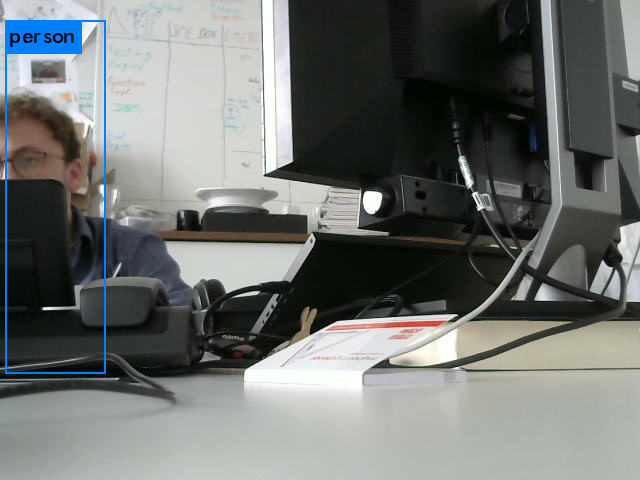

KeyboardInterrupt: 

In [48]:
vc = cv2.VideoCapture(0)
vc.set(cv2.CAP_PROP_FPS, 1)


while(1):
    start = time.time()
    #vc = cv2.VideoCapture(0)
    if vc.isOpened(): # try to get the first frame
        for i in range(7):
            vc.grab()
        is_capturing, frame_in = vc.read()
        frame = cv2.cvtColor(frame_in, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
        cv2.imwrite('frame.jpg', frame_in)
    #vc.release()
    end = time.time()
    #print(end-start)
    
    
    start = time.time()
    img_file = 'frame.jpg'#os.path.join(img_folder, image_name)
    file_name = c_char_p(img_file.encode())

    img = load_image(file_name,0,0)
    img_letterbox = letterbox_image(img,416,416)
    img_copy = np.copy(np.ctypeslib.as_array(img_letterbox.data, (3,416,416)))
    img_copy = np.swapaxes(img_copy, 0,2)
    free_image(img)
    free_image(img_letterbox)
    
    #print('Preprocessing')
    end = time.time()
    #print (end-start)
    
    start = time.time()
    #First convolution layer in sw
    if len(img_copy.shape)<4:
        img_copy = img_copy[np.newaxis, :, :, :]

    conv0_ouput = utils.conv_layer(img_copy,conv0_weights_correct,b=conv0_bias_broadcast,stride=2,padding=1)
    conv0_output_quant = conv0_ouput.clip(0.0,4.0)
    conv0_output_quant = utils.quantize(conv0_output_quant/4,3)
    
    #print('First Conv')

    #Offload to hardware
    conv_input = classifier.prepare_buffer(conv0_output_quant*7);
    classifier.inference(conv_input, conv_output)
    conv7_out = classifier.postprocess_buffer(conv_output)

    #Last convolution layer in sw
    conv7_out = conv7_out.reshape(out_dim,out_dim,out_ch)
    conv7_out = np.swapaxes(conv7_out, 0, 1) # exp 1
    if len(conv7_out.shape)<4:
        conv7_out = conv7_out[np.newaxis, :, :, :] 

    conv8_output = utils.conv_layer(conv7_out,conv8_weights_correct,b=conv8_bias_broadcast,stride=1)  
    conv8_out = conv8_output.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
    
    #print('done conv')
    end = time.time()
    #print (end-start)
    start = time.time()

    #Draw detection boxes
    lib.forward_region_layer_pointer_nolayer(net_darknet,conv8_out)
    lib.draw_detection_python(net_darknet, file_name, tresh, tresh_hier,file_names_voc, darknet_path, file_name_out, file_name_probs);
    
    #print('drawn boxes')
    #Display result
    IPython.display.clear_output(1)
    file_content = open(file_name_probs.value,"r").read().splitlines()
    detections = []
    for line in file_content[0:]:
        name, probability = line.split(": ")
        detections.append((probability, name))
    for det in sorted(detections, key=lambda tup: tup[0], reverse=True):
        print("class: {}\tprobability: {}".format(det[1], det[0]))
    res = Image.open(file_name_out.value.decode() + ".png")
    display(res)
    #print(detections)
    end = time.time()
    #print(end-start)

## 4. Deinitialisierung

In [49]:
classifier.deinit_accelerator()
from pynq import Xlnk

xlnk = Xlnk();
xlnk.xlnk_reset()

In [47]:
vc.release()
